# CS396 Data Science Project

### Project Overview
This project aims to understand any underlying biases or trends on Yelp by answering the following questions:
1. Is there a correlation between a user's activity and their average review star rating?
2. Can a review's text be used to caluclate its star rating?
3. Does whether a review was made during business hours correlate with its star rating?
4. Is there a relationship between a business' number of reviews and its star rating?

### Data Used
All of these questions were answered using various data sources included in the Yelp Open Dataset. The specific files used for each question are listed below:
1. user.json
2. review.json
3. review.json, business.json
4. business.json

## Environment Setup and Utility Functions

In [1]:
DATA_PATH = '../../yelp_dataset/'


from datetime import datetime
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import List, Tuple


def load_data(name: str) -> object:
    """Load Yelp data file.
    Currently only JSON and pickle file format supported
    
    Args:
        name (str):
            name of the file within the DATA_PATH directory
    Returns:
        Resulting DataFrame loaded from specified file    
    """
    f_type = name.split('.')[-1]
    
    if f_type == 'json': 
        return pd.DataFrame.from_records([json.loads(l) for l in open(DATA_PATH+path, encoding='utf-8')])
    elif f_type in ['pickle', 'pkl']:
        return pd.read_pickle(DATA_PATH+name)
    else:
        raise ValueError('Unsupported file type provided "{0}"'.format(f_type))
        

def save_data(df: object, name: str) -> None:
    """Save pd.DataFrame to specified file
    Currently only JSON and pickle file format supported
    
    Args:
        df (pd.DataFrame):
            pandas DataFrame object to save
        name (str)
            name of the file to save the DataFrame to
    Returns:
        None
    """
    f_type = name.split('.')[-1]
    
    if f_type == 'json':
        with open(DATA_PATH+name, 'w', encoding='utf-8') as out:
            for i, r in df.iterrows():
                print(r.to_json(), file=out)
        return
    elif f_type in ['pickle', 'pkl']:
        df.to_pickle(DATA_PATH+name)
        print('Data saved to {0}'.format(DATA_PATH+name))
        return
    else:
        raise ValueError('Unsupported file type provied "{0}"'.format(f_type))
 

def drop_null(df: object, subset: List[str] = None) -> Tuple[object, float, float]:
    """ Revmoe null entries from DataFrame
    
    Args:
        df (pd.DataFrame):
            pandas DataFrame object to remove null entries from
        subset (List[str]):
            optional subset of columns to drop null entires from
    Returns:
        A tuple of
            pd.DataFrame - resulting cleaned dataframe
            float - number of null entries dropped from DataFrame
            float - percent of total entries that were dropped from DataFrame
    function(pd.DataFrame, List[String]) => pd.DataFrame, Number, Number
    """
    # Remove null data
    clean = df.dropna() if not subset else df.dropna(subset=subset)
    
    # Compute statistics
    num_null = len(df) - len(clean)
    percent_null = (num_null / len(df)) * 100
    
    return clean, num_null, percent_null   


def in_business_hours(review_time: str, business_hours: dict) -> bool:
    """Determine if a review time is within a business' operating hours
    
    Args:
        review_time (str):
            string formatted review time from the Yelp review entry
        business_hours (dict):
            dictionary of business hours from the Yelp business entry
    Returns:
        A boolean indicated whether the review time falls within the business' hours
    """
    weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    rev_time = datetime.strptime(review_time, '%Y-%m-%d %H:%M:%S')
    rev_dow = weekdays[rev_time.weekday()]

    if rev_dow not in business_hours.keys():
        return False
    
    bus_hours = business_hours[rev_dow].split('-')
    open_time = datetime.strptime(bus_hours[0], '%H:%M')
    clos_time = datetime.strptime(bus_hours[1], '%H:%M')
    
    return open_time.time() <= rev_time.time() <= clos_time.time()

## Data Cleaning

### Convert JSON to Pickle
All of the data files that will be used are converted to pickle format for significantly faster load times and performance. This process takes a long time to complete (>20 minutes on my system) and requires significant computational resources (>8 GB RAM usage), but saves time in the long run with significantly decreased loading times for later access. This also slightly increases data density, saving about 1 GB in total across the files transcoded.

In [3]:
'''
# Commented out to prevent accidental execution
files = ['yelp_academic_dataset_user', 'yelp_academic_dataset_review', 'yelp_academic_dataset_business']
for f in files:
    df = load_data(f+'.json')
    save_data(df, f+'.pickle')
'''


### General Data Cleaning
The cleaning for each dataset is handled by its own clean_{dataset} function. This allows for more precising cleaning to be added in the future in the event that it is needed. For the analysis that will be performed here, there is very little data cleaning that needs to be performed; aside from dropping null values, the user and business datasets need to be checked for duplicate user_id and business\_id respectively. Upon analyzing the data used here, there were no such duplicates found, so the currently implementation of clean_{dataset} only serves as an alert of duplicate entries. There is no need to resolve any textual errors, such as an incorrect city name, as those will not be analyzed in this project and do not affect the other results. After the initial EDA, it was determined that users with more than 10,000 reviews are extreme outliers from the data and thus are removed in the data cleaning process.

#### User Data Cleaning

In [2]:
def clean_user(df: object) -> object:
    """Apply cleaning to user dataset formatted DataFrame
    
    Args:
        df (pd.DataFrame):
            user DataFrame object to clean
    Returns:
        cleaned DataFRame object
    """
    print('=== User Data Cleaning Results ===')
    
    # Clean out entries with null values
    clean, num_null, percent_null = drop_null(df)
    print('  Null entries dropped:  {0} ({1}%)'.format(num_null, round(percent_null, 2)))
    
    # Ensure no duplicate user_ids
    num_duplicates = len(clean) - len(clean.user_id.unique())
    print('  Duplicate user_id:     {0}'.format(num_duplicates))
    
    # Remove extreme activity outliers
    REVIEW_LIMIT = 10000
    print('  Outliers removed:      {0}'.format(sum(clean.review_count >= REVIEW_LIMIT)))
    clean = clean[clean.review_count < REVIEW_LIMIT]
    
    return clean

In [59]:
df = load_data('yelp_academic_dataset_user.pickle')
df = clean_user(df)

=== User Data Cleaning Results ===
  Null entries dropped:  0 (0.0%)
  Duplicate user_id:     0
  Outliers removed:      4


#### Business Data Cleaning

In [3]:
def clean_business(df: object) -> object:
    """Apply cleaning to business dataset formatted DataFrame
    
    Args:
        df (pd.DataFrame):
            user DataFrame object to clean
    Returns:
        cleaned DataFrame object
    """
    print("=== Business Data Cleaning Results ===")
    
    # Clean out null values
    clean, num_null, percent_null = drop_null(df, subset=['stars', 'review_count', 'is_open', 'hours'])
    print('  Null entries dropped:   {0} ({1}%)'.format(num_null, round(percent_null, 2)))
    
    # Ensure no duplicate business_id's
    num_duplicates = len(clean) - len(clean.business_id.unique())
    print('  Duplicate business_id:  {0}'.format(num_duplicates))
    
    return clean

In [22]:
df = load_data('yelp_academic_dataset_business.pickle')
df = clean_business(df)

=== Business Data Cleaning Results ===
  Null entries dropped:   27341 (17.03%)
  Duplicate business_id:  0


#### Review Data Cleaning

In [4]:
def clean_review(df: object) -> object:
    """Apply cleaning to review dataset formatted DataFrame
    
    Args:
        df (pd.DataFrame):
            review DataFrame object to clean
    Returns:
        cleaned DataFrame object
    """
    print("=== Review Data Cleaning Results ===")
    
    # Clean out null values
    clean, num_null, percent_null = drop_null(df)
    print('  Null entries dropped:  {0} ({1}%)'.format(num_null, round(percent_null, 2)))
    
    return clean

In [12]:
df = load_data('yelp_academic_dataset_review.pickle')
df = clean_review(df)

=== Review Data Cleaning Results ===
  Null entries dropped:  0 (0.0%)


## Exploratory Data Analysis

### Business Data

In [168]:
df = clean_business(load_data('yelp_academic_dataset_business.pickle'))

=== Business Data Cleaning Results ===
  Null entries dropped:   27341 (17.03%)
  Duplicate business_id:  0


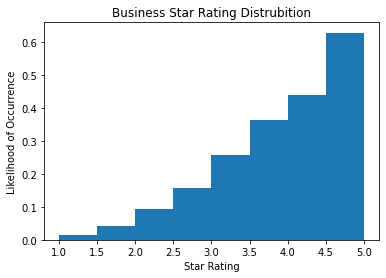

In [169]:
plt.hist(df.stars, bins=[1,1.5,2,2.5,3,3.5,4,4.5,5], density=True)
plt.title('Business Star Rating Distrubition')
plt.ylabel('Likelihood of Occurrence')
plt.xlabel('Star Rating')
plt.show()

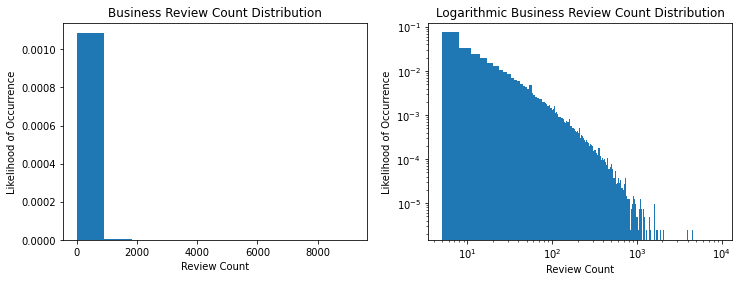

In [170]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].hist(df.review_count, density=True)
ax[0].set_title('Business Review Count Distribution')
ax[0].set_ylabel('Likelihood of Occurrence')
ax[0].set_xlabel('Review Count')

ax[1].hist(df.review_count, 3000, density=True)
ax[1].set_title('Logarithmic Business Review Count Distribution')
ax[1].set_ylabel('Likelihood of Occurrence')
ax[1].set_yscale('log')
ax[1].set_xlabel('Review Count')
ax[1].set_xscale('log')

plt.show()

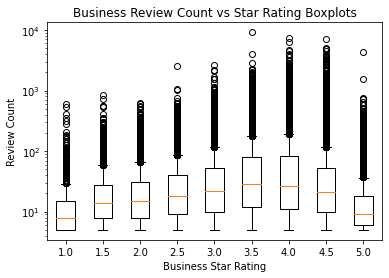

In [172]:
star_values = [i*0.5 + 0.5 for i in range(1,10)]
star_bins = [df[df.stars==s].review_count for s in star_values]

plt.boxplot(star_bins)
plt.xticks(list(range(1,10)), star_values)
plt.title('Business Review Count vs Star Rating Boxplots')
plt.ylabel('Review Count')
plt.yscale('log')
plt.xlabel('Business Star Rating')

plt.show()

### User Data

In [173]:
df = clean_user(load_data('yelp_academic_dataset_user.pickle'))

=== User Data Cleaning Results ===
  Null entries dropped:  0 (0.0%)
  Duplicate user_id:     0
  Outliers removed:      4


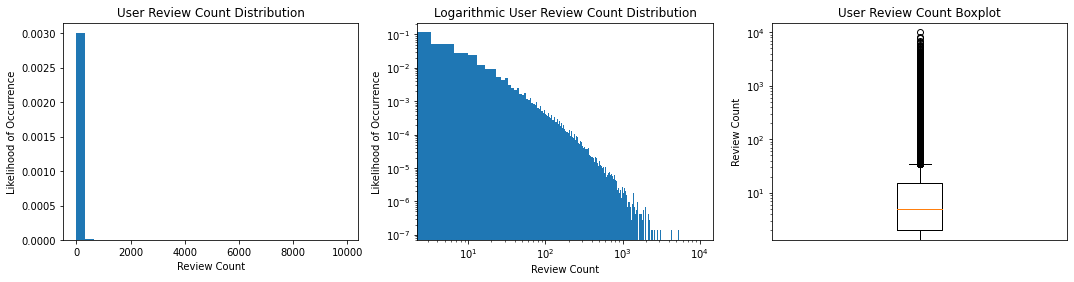

In [44]:
fig, ax = plt.subplots(1,3, figsize=(18,4))

ax[0].hist(df.review_count, 30, density=True)
ax[0].set_title('User Review Count Distribution')
ax[0].set_ylabel('Likelihood of Occurrence')
ax[0].set_xlabel('Review Count')

ax[1].hist(df.review_count, 3000, density=True)
ax[1].set_title('Logarithmic User Review Count Distribution')
ax[1].set_ylabel('Likelihood of Occurrence')
ax[1].set_yscale('log')
ax[1].set_xlabel('Review Count')
ax[1].set_xscale('log')

ax[2].boxplot(df.review_count)
ax[2].set_title('User Review Count Boxplot')
ax[2].set_ylabel('Review Count')
ax[2].set_yscale('log')
ax[2].set_xticks([])

plt.show()

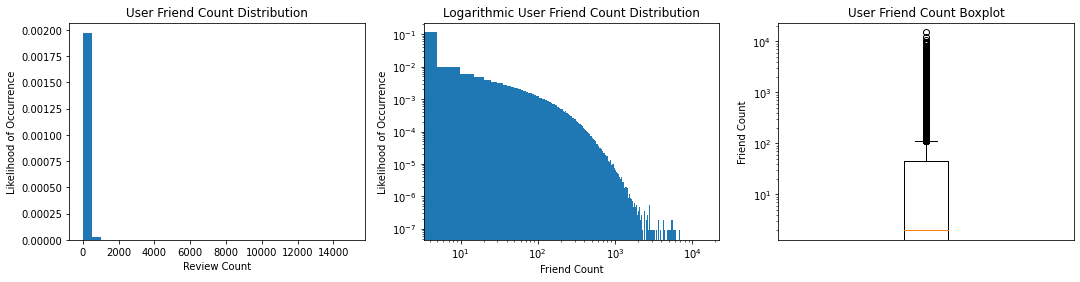

In [58]:
count_friends = lambda x: len(x.split(',')) if x != 'None' else 0
friend_count = df.friends.map(count_friends)

fig, ax = plt.subplots(1,3, figsize=(18,4))

ax[0].hist(friend_count, 30, density=True)
ax[0].set_title('User Friend Count Distribution')
ax[0].set_ylabel('Likelihood of Occurrence')
ax[0].set_xlabel('Review Count')

ax[1].hist(friend_count, 3000, density=True)
ax[1].set_title('Logarithmic User Friend Count Distribution')
ax[1].set_ylabel('Likelihood of Occurrence')
ax[1].set_yscale('log')
ax[1].set_xlabel('Friend Count')
ax[1].set_xscale('log')

ax[2].boxplot(friend_count)
ax[2].set_title('User Friend Count Boxplot')
ax[2].set_ylabel('Friend Count')
ax[2].set_yscale('log')
ax[2].set_xticks([])

plt.show()

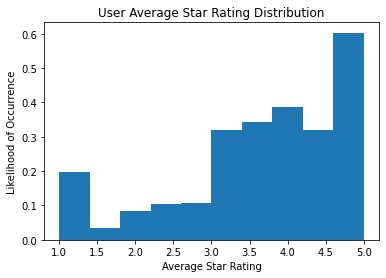

In [175]:
plt.hist(df.average_stars, density=True)
plt.title('User Average Star Rating Distribution')
plt.ylabel('Likelihood of Occurrence')
plt.xlabel('Average Star Rating')
plt.show()

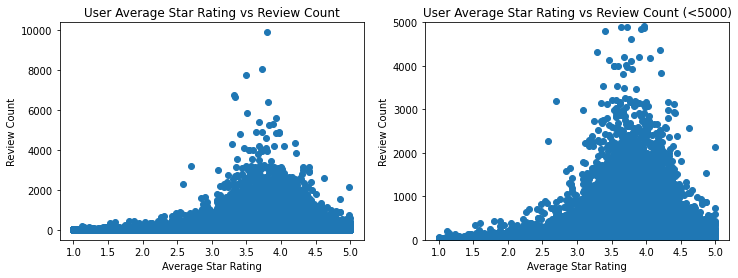

In [190]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].scatter(df.average_stars, df.review_count)
ax[0].set_title('User Average Star Rating vs Review Count')
ax[0].set_ylabel('Review Count')
ax[0].set_xlabel('Average Star Rating')

limit = 5000
ax[1].scatter(df.average_stars, df.review_count)
ax[1].set_title('User Average Star Rating vs Review Count (<{0})'.format(limit))
ax[1].set_ylabel('Review Count')
ax[1].set_ylim(0, limit)
ax[1].set_xlabel('Average Star Rating')

plt.show()

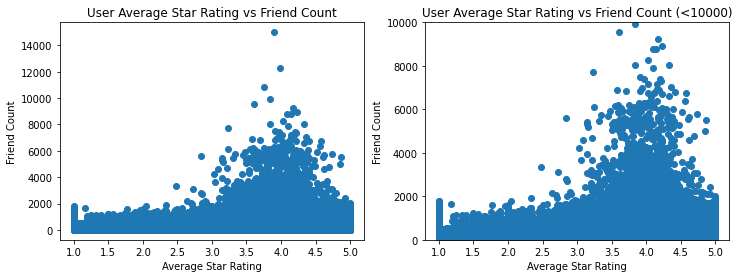

In [191]:
count_friends = lambda x: len(x.split(',')) if x != 'None' else 0
df['friend_count'] = df.friends.map(count_friends)

fig, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].scatter(df.average_stars, df.friend_count)
ax[0].set_title('User Average Star Rating vs Friend Count')
ax[0].set_ylabel('Friend Count')
ax[0].set_xlabel('Average Star Rating')

limit = 10000
ax[1].scatter(df.average_stars, df.friend_count)
ax[1].set_title('User Average Star Rating vs Friend Count (<{0})'.format(limit))
ax[1].set_ylabel('Friend Count')
ax[1].set_ylim(0, limit)
ax[1].set_xlabel('Average Star Rating')

plt.show()

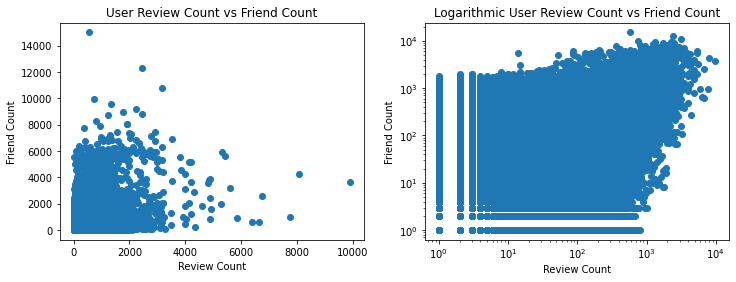

In [184]:
count_friends = lambda x: len(x.split(',')) if x != 'None' else 0
friend_count = df.friends.map(count_friends)

fig, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].scatter(df.review_count, friend_count)
ax[0].set_title('User Review Count vs Friend Count')
ax[0].set_xlabel('Review Count')
ax[0].set_ylabel('Friend Count')

ax[1].scatter(df.review_count, friend_count)
ax[1].set_title('Logarithmic User Review Count vs Friend Count')
ax[1].set_xlabel('Review Count')
ax[1].set_xscale('log')
ax[1].set_ylabel('Friend Count')
ax[1].set_yscale('log')


plt.show()

In [6]:
def count_friends_in_data(friends: object, users: object) -> object:
    """Count number of friends for each user present in user dataset 
    
    Args:
        friends (pd.Series): 
            series of lists of users' friends
        users (pd.Series):
            series of all user_id available in dataset
    Returns:
        pandas Series object with count of how many friends from each
        user's friend list are present in the user dataset
    """
    def helper(friend_list):
        if friend_list == 'None':
            return 0
        return sum([(users==f).any() for f in friend_list.split(', ')])
    
    return friends.map(helper)

In [103]:
count_friends_in_data(df.friends[10:20], df.user_id)

10     48
11     13
12    158
13     95
14     13
15    145
16    191
17     39
18     84
19     56
Name: friends, dtype: int64

### Review Data

In [192]:
df = clean_review(load_data('yelp_academic_dataset_review.pickle'))

=== Review Data Cleaning Results ===
  Null entries dropped:  0 (0.0%)


In [128]:
print('          Number of Reviews: {0}'.format(len(df)))
print('     Number of Unique Users: {0}'.format(len(df.user_id.unique())))
print('Number of Unique Businesses: {0}'.format(len(df.business_id.unique())))

          Number of Reviews: 8635403
     Number of Unique Users: 2189457
Number of Unique Businesses: 160585


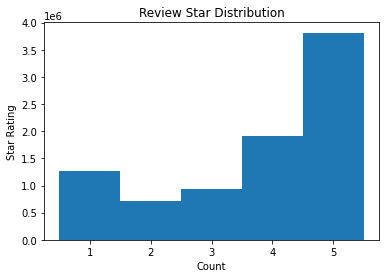

In [129]:
plt.hist(df.stars, bins=[s+0.5 for s in range(0,6)])
plt.title('Review Star Distribution')
plt.ylabel('Star Rating')
plt.xlabel('Count')
plt.show()

=== Reviews by User Summary ===
  Max:    6073
  Mean:   3.944084309488608
  Median: 1.0
  Min:    1


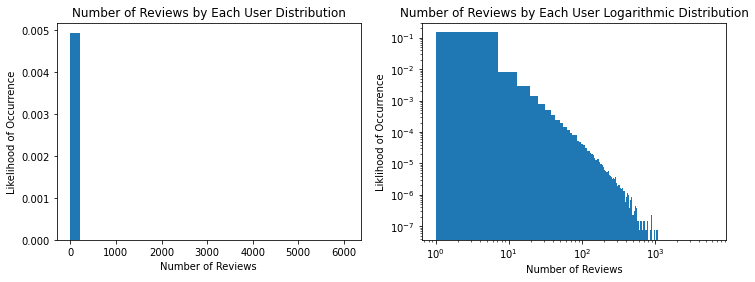

In [69]:
# Count number of reviews by each user in Review set
review_count_user = df.user_id.value_counts()

print('=== Reviews by User Summary ===')
print('  Max:    {0}'.format(max(review_count_user)))
print('  Mean:   {0}'.format(review_count_user.mean()))
print('  Median: {0}'.format(review_count_user.median()))
print('  Min:    {0}'.format(min(review_count_user)))

fig, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].hist(review_count_user, 30, density=True)
ax[0].set_title('Number of Reviews by Each User Distribution')
ax[0].set_xlabel('Number of Reviews')
ax[0].set_ylabel('Likelihood of Occurrence')

ax[1].hist(review_count_user, 1000, density=True)
ax[1].set_title('Number of Reviews by Each User Logarithmic Distribution')
ax[1].set_xlabel('Number of Reviews')
ax[1].set_xscale('log')
ax[1].set_ylabel('Liklihood of Occurrence')
ax[1].set_yscale('log')

=== Reviews of Business Summary ===
  Max:    6073
  Mean:   3.944084309488608
  Median: 1.0
  Min:    1


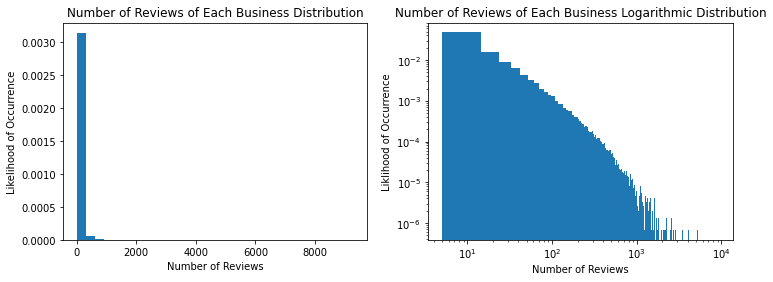

In [70]:
# Count number of reviews for each business in Review set
review_count_business = df.business_id.value_counts()

print('=== Reviews of Business Summary ===')
print('  Max:    {0}'.format(max(review_count_user)))
print('  Mean:   {0}'.format(review_count_user.mean()))
print('  Median: {0}'.format(review_count_user.median()))
print('  Min:    {0}'.format(min(review_count_user)))


fig, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].hist(review_count_business, 30, density=True)
ax[0].set_title('Number of Reviews of Each Business Distribution')
ax[0].set_xlabel('Number of Reviews')
ax[0].set_ylabel('Likelihood of Occurrence')

ax[1].hist(review_count_business, 1000, density=True)
ax[1].set_title('Number of Reviews of Each Business Logarithmic Distribution')
ax[1].set_xlabel('Number of Reviews')
ax[1].set_xscale('log')
ax[1].set_ylabel('Liklihood of Occurrence')
ax[1].set_yscale('log')

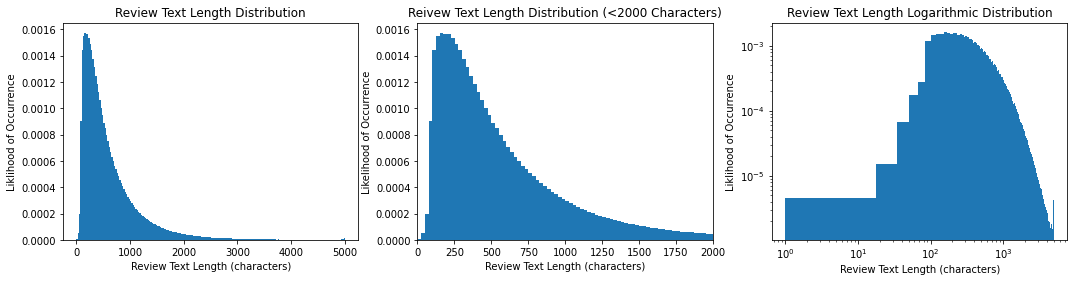

In [63]:
text_len = df.text.map(len)

fig, ax = plt.subplots(1,3, figsize=(18,4))

ax[0].hist(text_len, 200, density=True)
ax[0].set_title('Review Text Length Distribution')
ax[0].set_xlabel('Review Text Length (characters)')
ax[0].set_ylabel('Liklihood of Occurrence')

ax[1].hist(text_len, 200, density=True)
ax[1].set_title('Reivew Text Length Distribution (<2000 Characters)')
ax[1].set_xlabel('Review Text Length (characters)')
ax[1].set_xlim(0, 2000)
ax[1].set_ylabel('Likelihood of Occurrence')

ax[2].hist(text_len, 300, density=True)
ax[2].set_title('Review Text Length Logarithmic Distribution')
ax[2].set_xlabel('Review Text Length (characters)')
ax[2].set_xscale('log')
ax[2].set_ylabel('Liklihood of Occurrence')
ax[2].set_yscale('log')

plt.show()

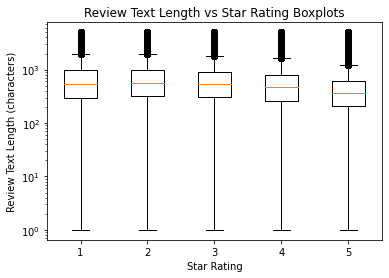

In [195]:
star_values = [i for i in range(1,6)]
star_bins = [df[df.stars==s].text.map(len) for s in star_values]

plt.boxplot(star_bins)
plt.title('Review Text Length vs Star Rating Boxplots')
plt.xlabel('Star Rating')
plt.ylabel('Review Text Length (characters)')
plt.yscale('log')

plt.show()

### Combinations of Data

In [196]:
df_bus = clean_business(load_data('yelp_academic_dataset_business.pickle'))
df_rev = clean_review(load_data('yelp_academic_dataset_review.pickle'))

=== Business Data Cleaning Results ===
  Null entries dropped:   27341 (17.03%)
  Duplicate business_id:  0
=== Review Data Cleaning Results ===
  Null entries dropped:  0 (0.0%)


In [71]:
def inhours_df(review_data: object, business_data: object) -> object:
    """Generate in_hours classifier DataFrame

    Args:
        review_data (pd.DataFrame):
            Yelp review dataset
        business_data (pd.DataFrame):
            Yelp business dataset
    Returns:
        pandas DataFrame object with the following columns:
            business_id
            review_id
            stars
            date
            hours
            in_hours
    """
    q3 = review_data[['business_id', 'review_id', 'stars', 'date']]
    q3 = q3.merge(business_data[['business_id', 'hours', 'state']])
    
    in_hours = lambda r: in_business_hours(r.date, r.hours)
    q3['in_hours'] = q3.apply(in_hours, axis=1)
    return q3 

In [159]:
# q3 = inhours_(df_rev, df_bus)
q3 = inhours_df(df_rev.sample(n=10000), df_bus)

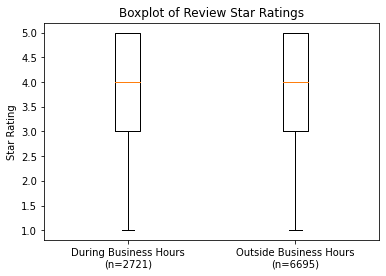

In [198]:
stars_in_hours = q3[q3.in_hours].stars
stars_out_hours = q3[~q3.in_hours].stars

plt.boxplot([stars_in_hours, stars_out_hours])
plt.title('Boxplot of Review Star Ratings')
plt.ylabel('Star Rating')
plt.xticks([1,2], ['During Business Hours\n(n={0})'.format(len(stars_in_hours)), 'Outside Business Hours\n(n={0})'.format(len(stars_out_hours))])

plt.show()

## Statistics and Modeling

### Problem 1: User Activity and Average Rating

In [129]:
df = clean_user(load_data('yelp_academic_dataset_user.pickle'))

=== User Data Cleaning Results ===
  Null entries dropped:  0 (0.0%)
  Duplicate user_id:     0
  Outliers removed:      4


In [130]:
count_friends = lambda x: len(x.split(',')) if x != 'None' else 0
df['friend_count'] = df.friends.map(count_friends)

In [639]:
from scipy.stats import pearsonr, spearmanr

reviews_pearson = pearsonr(df.review_count, df.average_stars)
reviews_spearman = spearmanr(df.review_count, df.average_stars)

friends_pearson = pearsonr(df.friend_count, df.average_stars)
friends_spearman = spearmanr(df.friend_count, df.average_stars)

print('=== Review Count vs Average Stars ===')
print('  Pearson  : {0}'.format(reviews_pearson))
print('  Spearman : {0}'.format(reviews_spearman))
print('=== Friend Count vs Average Stars ===')
print('  Pearson  : {0}'.format(friends_pearson))
print('  Spearman : {0}'.format(friends_spearman))

=== Review Count vs Average Stars ===
  Pearson  : (0.038047942217639456, 0.0)
  Spearman : SpearmanrResult(correlation=-0.0029122457398685258, pvalue=1.638472235305368e-05)
=== Friend Count vs Average Stars ===
  Pearson  : (0.05780822742976715, 0.0)
  Spearman : SpearmanrResult(correlation=0.06910872458630603, pvalue=0.0)


In [449]:
from sklearn.linear_model import LinearRegression
import numpy as np

n = 10000
train_test_split = 4*n//5
feat = ['review_count']
targ = 'average_stars'

sample = df[df.review_count != 0]
sample = sample[sample.friend_count != 0]
sample = sample.sample(n=n)

train_feat = np.log(sample[:train_test_split][feat])
train_targ = sample[:train_test_split][targ]
test_feat = np.log(sample[train_test_split:][feat])
test_targ = sample[train_test_split:][targ]

lin = LinearRegression()
lin.fit(train_feat, train_targ)
lin.score(test_feat, test_targ)

0.009880081276618546

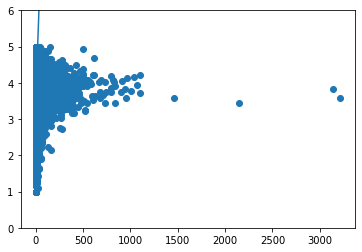

In [453]:
plt.scatter(sample.review_count, sample.average_stars)
plt.ylim(0, 6)
ls = np.linspace(0, 2500)
ls_y = lin.coef_[0]*ls + lin.intercept_
plt.plot(ls, ls_y)

Text(0.5, 0, 'average_stars')

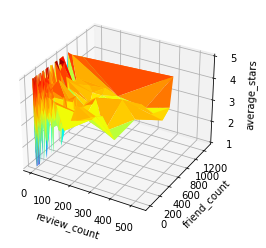

In [451]:
import matplotlib.pyplot as plt
from matplotlib import cm

x = 'review_count'
y = 'friend_count'
z = 'average_stars'

ax = plt.axes(projection='3d')
ax.plot_trisurf(
    sample[:1000][x], 
    sample[:1000][y], 
    sample[:1000][z], 
    linewidth=0, 
    antialiased=True, 
    cmap=cm.jet
)
ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_zlabel(z)

In [640]:
ax = pd.plotting.scatter_matrix(df[['review_count', 'friend_count', 'average_stars', 'cool', 'useful', 'funny', 'compliment_cool', 'compliment_writer']], figsize=(25, 25))
plt.show()

In [148]:
import plotly
import plotly.graph_objects as go
import plotly.io as pio

pio.renderers.default = 'browser'


fig = go.Figure()

sample = df.sample(n=500)

fig.add_traces( 
    go.Scatter3d(
        x = sample.review_count,
        y = sample.friend_count,
        z = sample.useful,
        mode='markers',
        marker=dict(
            size=12,
            color=sample.average_stars,
            colorscale='Viridis',
            opacity=1,
            colorbar = dict(thickness = 10),
            colorbar_title = 'Average Star Rating'
        )
    )
)

fig.update_layout(
    title = 'User Activity vs Star Count',
    title_x = 0.5,
    scene = dict(
        xaxis_title= 'Review Count',
        xaxis_type= 'log',
        yaxis_title= 'Friend Count',
        yaxis_type= 'log',
        zaxis_title= 'Useful Votes Sent',
        zaxis_type= 'log'
    )
)
plotly.offline.plot(fig, filename='user_activity_scatter.html')
fig.show()

In [132]:
df['group_stars'] = (df.average_stars * 2).round(0) / 2

In [149]:
group_stars = df.groupby('group_stars').median()

fig = go.Figure()

fig.add_traces( 
    go.Scatter3d(
        x = group_stars.review_count.values,
        y = group_stars.friend_count.values,
        z = group_stars.useful.values,
        mode='markers',
        name='Median Values',
        marker=dict(
            size=12,
            color=group_stars.fans.index,
            colorscale='Viridis',
            opacity=1,
            colorbar = dict(thickness = 10),
            colorbar_title = 'Average Star Rating'
        )
    )
)

fig.add_traces( 
    go.Scatter3d(
        x = group_stars.review_count.values,
        y = group_stars.friend_count.values,
        z = group_stars.useful.values,
        mode='lines',
        name='Connecting Line'
    )
)

fig.update_layout(
    title = 'User Activity vs Star Count',
    title_x = 0.5,
    legend_orientation = 'h',
    scene = dict(
        xaxis_title= 'Review Count',
        yaxis_title= 'Friend Count',
        zaxis_title= 'Useful Votes Sent'
    )
)
plotly.offline.plot(fig, filename='user_activity_line.html')
fig.show()

### Problem 2: Review Text vs Star Rating

In [63]:
df = clean_review(load_data('yelp_academic_dataset_review.pickle'))
df = df[['text', 'stars']]

=== Review Data Cleaning Results ===
  Null entries dropped:  0 (0.0%)


In [7]:
from scipy.stats import pearsonr, spearmanr

df['textlen'] = df[['text']].applymap(len)

text_pearson = pearsonr(df.textlen, df.stars)
text_spearman = spearmanr(df.textlen, df.stars)

print('=== Review Text Length vs Star Rating ===')
print('  Pearson  : {0}'.format(text_pearson))
print('  Spearman : {0}'.format(text_spearman))

=== Review Text Length vs Star Rating ===
  Pearson  : (-0.1853451377786109, 0.0)
  Spearman : SpearmanrResult(correlation=-0.20419977610266674, pvalue=0.0)


In [8]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def sentiment_df(text_series):
    """ Create sentiment DataFrame for a given Series of text
    
    Args:
        text_series (pd.Series):
            series of text 
    Returns:
        DataFrame with columns of the sentiment values from the
        nltk SentimentIntensityAnalyzer class. Specifically, the
        column values are:
            neg
            neu
            pos
    """
    sia = SentimentIntensityAnalyzer()
    
    sentiments = text_series.apply(
        lambda t: list(sia.polarity_scores(t).values())[:3]
    ).tolist()
    
    return pd.DataFrame(sentiments, columns=['neg', 'neu', 'pos'])

In [162]:
df = df.join(sentiment_df(df['text']))
save_data(df, 'review_sentiment.pickle')

In [150]:
df = load_data('review_sentiment.pickle')

In [157]:
df['textlen'] = df.text.apply(len)

In [217]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

cv = cross_val_score(GradientBoostingRegressor(), df[['neg', 'pos', 'textlen']], df['stars'], cv=3)

In [236]:
n = 10000
sample = df.sample(n=n)

train = sample[:4*n//5]
test = sample[n//5:]

train_feat = train[['neg', 'neu', 'pos']]
train_targ = train['stars']
test_feat = test[['neg', 'neu', 'pos']]
test_targ = test['stars']

from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor()
gbr.fit(train_feat, train_targ)
print('=== Gradient Boosting Regressor ===')
print('  R^2: {0}'.format(gbr.score(test_feat, test_targ)))
print('  Feature Importances: {0}'.format(gbr.feature_importances_))

from sklearn.linear_model import LinearRegression

linear = LinearRegression()
linear.fit(train_feat, train_targ)
print('\n=== Linear Regression ===')
print('  R^2: {0}'.format(linear.score(test_feat, test_targ)))
print('  Coefficients: {0}'.format(linear.coef_))

=== Gradient Boosting Regressor ===
  R^2: 0.5314094895662334
  Feature Importances: [0.22506617 0.01153025 0.76340358]

=== Linear Regression ===
  R^2: 0.40816319388662836
  Coefficients: [-8.54630138  0.25556125  5.39673278]


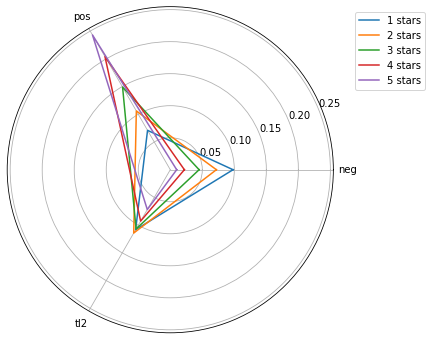

In [61]:
median = df.groupby('stars').median()
cols = ['neg', 'pos', 'tl2']

from math import pi
from numpy import linspace
theta = linspace(0, 2*pi, len(cols)+1)

plt.figure(figsize=(6,6))
plt.polar()
for i in range(0, 5):
    d = list(median.iloc[i][cols])
    d.append(d[0])
    plt.plot(theta, d, label='{0} stars'.format(i+1))
plt.xticks(theta[:-1], cols)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

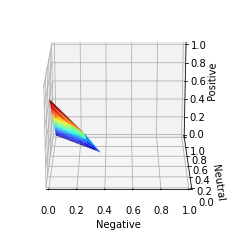

In [320]:
import matplotlib.pyplot as plt
from matplotlib import cm

plt.figure()
ax = plt.axes(projection='3d')
ax.plot_trisurf(
    df[:1000].neg, 
    df[:1000].neu, 
    df[:1000].pos, 
    linewidth=0, 
    antialiased=True, 
    cmap=cm.jet
)
ax.set_xlim(0, 1)
ax.set_xlabel('Negative')
ax.set_ylim(0, 1)
ax.set_ylabel('Neutral')
ax.set_zlim(0, 1)
ax.set_zlabel('Positive')
ax.view_init(20, -90)

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

df['stars'] = df[['stars']].astype(int)

feat = ['neg', 'neu', 'pos']
targ = 'stars'

sample = df.sample(n=100000)

cv = cross_val_score(LogisticRegression(max_iter=200, n_jobs=-1), sample[feat], sample[targ], cv=5)
cv.mean()

0.5406

In [166]:
import plotly
import plotly.io as pio
import plotly.graph_objects as go
import numpy as np

pio.renderers.default = 'browser'

median = df.groupby('stars').median()
sample = df.sample(n=10000)

fig = go.Figure()
'''
fig.add_traces(
    go.Scatter3d(
        x = sample.pos,
        y = sample.neg,
        z = sample.textlen,
        mode='markers',
        marker=dict(
            size=6,
            color=sample.stars,
            colorscale='Viridis',
            opacity=1,
            colorbar = dict(thickness = 10),
            colorbar_title = 'Review Star Rating'
        )
    )
)
#'''
fig.add_traces( 
    go.Scatter3d(
        x = median.pos.values,
        y = median.neg.values,
        z = median.textlen.values,
        mode='markers',
        name='Median Values',
        marker=dict(
            size=12,
            color=median.pos.index,
            colorscale='Viridis',
            opacity=1,
            colorbar = dict(thickness = 10),
            colorbar_title = 'Review Star Rating'
        )
    )
)
fig.add_traces(
    go.Scatter3d(
        x = median.pos.values,
        y = median.neg.values,
        z = median.textlen.values,
        name='Connecting Line',
        mode='lines'
    )
)
#'''

fig.update_layout(
    title = 'Business Star Rating vs Business Review Count Distribution',
    legend_orientation = 'h',
    title_x = 0.5,
    scene = dict(
        xaxis_title= 'Positive Text Sentiment',
        yaxis_title= 'Negative Text Sentiment',
        zaxis_title= 'Text Length'
    )
)

#plotly.offline.plot(fig, filename='sentiment_points.html')
plotly.offline.plot(fig, filename='sentiment_line.html')
fig.show()

### Problem 3: Review In Business Hours vs Star Rating

In [69]:
df_rev = clean_review(load_data('yelp_academic_dataset_review.pickle'))
df_bus = clean_business(load_data('yelp_academic_dataset_business.pickle'))

=== Review Data Cleaning Results ===
  Null entries dropped:  0 (0.0%)
=== Business Data Cleaning Results ===
  Null entries dropped:   27341 (17.03%)
  Duplicate business_id:  0


In [136]:
df = inhours_df(df_rev, df_bus)
save_data(df, 'review_inhours.pickle')

Data saved to ../../yelp_dataset/review_inhours.pickle


In [37]:
df = load_data('review_inhours.pickle')

In [691]:
from scipy.stats import ks_2samp

# Assumptions not satisfied because distribution not fully definedW
ks_2samp(df[df.in_hours].stars, df[~df.in_hours].stars)

KstestResult(statistic=0.012296752884404016, pvalue=7.521475510651733e-218)

In [687]:
mean = df.groupby('stars').mean()

In [688]:
(df.groupby('stars').count()) / len(df) 

,business_id,review_id,date,hours,state,in_hours
stars,,,,,,
1.0,0.140317,0.140317,0.140317,0.140317,0.140317,0.140317
2.0,0.081824,0.081824,0.081824,0.081824,0.081824,0.081824
3.0,0.106805,0.106805,0.106805,0.106805,0.106805,0.106805
4.0,0.223086,0.223086,0.223086,0.223086,0.223086,0.223086
5.0,0.447969,0.447969,0.447969,0.447969,0.447969,0.447969


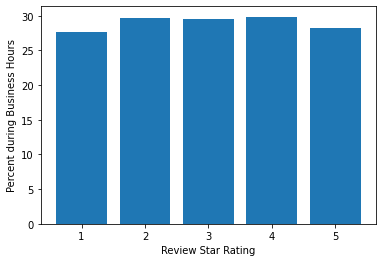

In [689]:
plt.bar(mean.index.astype(int), 100*mean.values.T[0])
plt.title('')
plt.ylabel('Percent during Business Hours')
plt.xlabel("Review Star Rating")
plt.show()

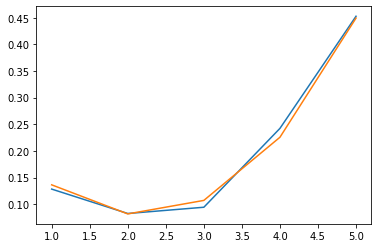

In [134]:
count_in = df[df.in_hours].groupby('stars').count()
count_out = df[~df.in_hours].groupby('stars').count()
plt.plot(
    list(range(1,6)),
    count_in.values.T[0] / sum(count_in.values.T[0])
)
plt.plot(
    list(range(1,6)),
    count_out.values.T[0] / sum(count_out.values.T[0])
)

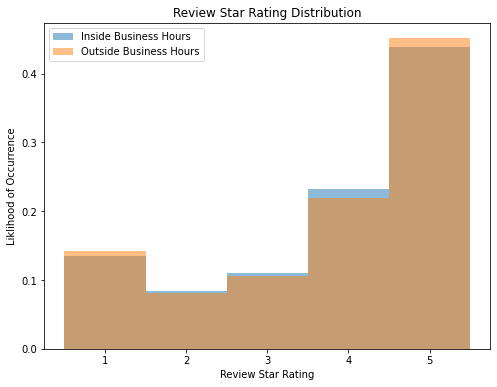

In [140]:
plt.figure(figsize=(8,6))
plt.title('Review Star Rating Distribution')
plt.xlabel('Review Star Rating')
plt.ylabel('Liklihood of Occurrence')

bins = [i+0.5 for i in range(0, 6)]
plt.hist(
    df[df.in_hours].stars, 
    bins=bins, 
    alpha=0.5, 
    label='Inside Business Hours', 
    density=True
)
plt.hist(
    df[~df.in_hours].stars, 
    bins=bins, 
    alpha=0.5, 
    label='Outside Business Hours', 
    density=True
)
plt.legend()
plt.show()

In [38]:
import plotly
import plotly.io as pio
import plotly.graph_objects as go

pio.renderers.default = 'browser'


fig = go.Figure()
fig.add_trace(
    go.Histogram(
        x=df[df.in_hours].stars,
        histnorm='probability',
        name='During Business Hours',
        opacity=0.75,
        marker = dict(color = 'blue')
    )
)
fig.add_trace(
    go.Histogram(
        x=df[~df.in_hours].stars,
        histnorm='probability',
        name='Outside Business Hours',
        opacity=0.75,
        marker = dict(color = 'red')
    )
)


fig.update_layout(
    title='Review Star Distribution',
    title_x=0.5,
    barmode='overlay',
    xaxis_title='Star Rating',
    yaxis_title='Proportion of Reviews'
)

plotly.offline.plot(fig, filename='review_inhours_hist.html')
fig.show()

In [41]:
fig = go.Figure()

fig.add_trace(
    go.Box(
        x = df[df.in_hours].stars,
        name='During Business Hours',
        marker = dict(color = 'blue'),
        showlegend = False
    )
)
fig.add_trace(
    go.Box(
        x = df[df.in_hours].stars,
        name='Outside Business Hours',
        marker = dict(color = 'red'),
        showlegend = False
    )
)

fig.update_layout(
    title='Review Star Boxplots',
    title_x=0.5,
    xaxis_title='Star Rating'
)

plotly.offline.plot(fig, filename='review_inhours_box.html')
fig.show()

### Problem 4: Business Review Count vs Star Rating

In [42]:
df = clean_business(load_data('yelp_academic_dataset_business.pickle'))

=== Business Data Cleaning Results ===
  Null entries dropped:   27341 (17.03%)
  Duplicate business_id:  0


In [275]:
import numpy as np

df['stars_2'] = df[['stars']] ** 2
df['stars_3'] = df[['stars']] ** 3
df['log_review_count'] = np.log(df[['review_count']])

In [282]:
from scipy.stats import pearsonr, spearmanr

review_pearson = pearsonr(df.log_review_count, df.stars)
review_spearman = spearmanr(df.log_review_count, df.stars)

print('=== Business Review Count vs Star Rating ===')
print('  Pearson  : {0}'.format(review_pearson))
print('  Spearman : {0}'.format(review_spearman))

=== Business Review Count vs Star Rating ===
  Pearson  : (-0.027296347073224092, 2.1548072019241416e-23)
  Spearman : SpearmanrResult(correlation=-0.08159914204087725, pvalue=1.3622892060012781e-195)


In [300]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

cv = cross_val_score(
    LinearRegression(),
    df[['log_review_count']],
    df.stars,
    cv=3
)
print("""
stars = a0 + a1*log_review_count
       R^2: {0}
  Mean R^2: {1}
""".format(cv, cv.mean()))

cv = cross_val_score(
    LinearRegression(),
    df[['stars']],
    df.log_review_count,
    cv=3
)
print("""
log_review_count = a0 + a1*stars
       R^2: {0}
  Mean R^2: {1}
""".format(cv, cv.mean()))

cv = cross_val_score(
    LinearRegression(),
    df[['stars', 'stars_2']],
    df.log_review_count,
    cv=3
)
print("""
log_review_count = a0 + a1*stars + a2*stars_2
       R^2: {0}
  Mean R^2: {1}
""".format(cv, cv.mean()))

cv = cross_val_score(
    LinearRegression(), 
    df[['stars', 'stars_2', 'stars_3']],
    df.log_review_count,
    cv=3
)
print("""
log_review_count = a0 + a1*stars + a2*stars_2 + a3*stars_3
       R^2: {0}
  Mean R^2: {1}
""".format(cv, cv.mean()))




stars = a0 + a1*log_review_count
       R^2: [0.00077081 0.0006902  0.00076963]
  Mean R^2: 0.0007435449987018098


log_review_count = a0 + a1*stars
       R^2: [0.00077207 0.00068973 0.00076782]
  Mean R^2: 0.0007432101654274806


log_review_count = a0 + a1*stars + a2*stars_2
       R^2: [0.06023385 0.06683406 0.06364957]
  Mean R^2: 0.06357249088109014


log_review_count = a0 + a1*stars + a2*stars_2 + a3*stars_3
       R^2: [0.0776869  0.08385565 0.08101363]
  Mean R^2: 0.08085206089245456



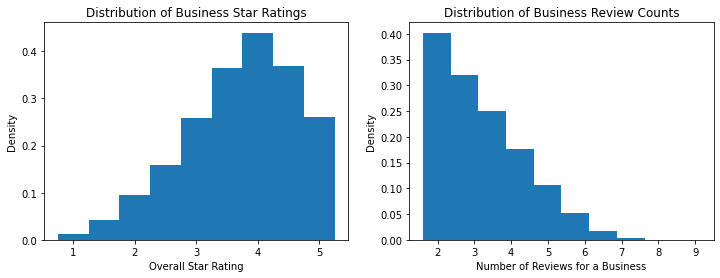

In [314]:
bins = [0.5*i+0.75 for i in range(0, 10)]

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].hist(
    df.stars, 
    bins=bins,
    density=True
)
ax[0].set_title('Distribution of Business Star Ratings')
ax[0].set_xlabel('Overall Star Rating')
ax[0].set_ylabel('Density')

ax[1].hist(
    df.log_review_count,
    density=True
)
ax[1].set_title('Distribution of Business Review Counts')
ax[1].set_xlabel('Number of Reviews for a Business')
ax[1].set_ylabel('Density')

plt.show()

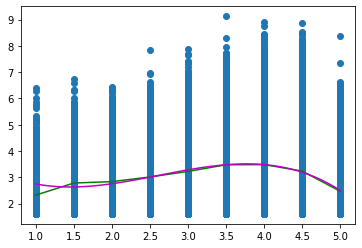

In [324]:
plt.scatter(
    df.stars,
    df.log_review_count
)

group_star = df.groupby('stars')
plt.plot(
    group_star.log_review_count.mean().index,
    group_star.log_review_count.mean(),
    color = 'g',
    label = 'Scatterplot Points'
)



lin = LinearRegression()
lin.fit(
    df[['stars', 'stars_2', 'stars_3']], 
    df.log_review_count
)

x = np.linspace(1,5)
y = lin.coef_[0]*x + lin.coef_[1]*(x**2) + lin.coef_[2]*(x**3) + lin.intercept_

plt.plot(
    x, 
    y,
    color='m'
)

Text(0.5, 0, 'Density')

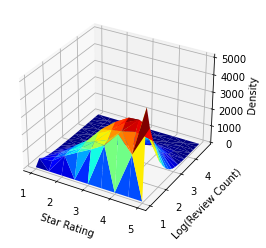

In [421]:
from matplotlib import cm


ax = plt.axes(projection='3d')
ax.plot_trisurf(
    x.ravel(), 
    y.ravel(), 
    z.ravel(), 
    linewidth=0, 
    antialiased=True,
    cmap = cm.jet
)
ax.set_xlabel('Star Rating')
ax.set_ylabel('Log(Review Count)')
ax.set_zlabel('Density')

In [128]:
import plotly
import plotly.io as pio
import plotly.graph_objects as go
import numpy as np

pio.renderers.default = 'browser'

ag = df.groupby('stars').agg({'review_count': list})

nbins = 20
nstars = len(ag.index)

bins = np.exp(np.linspace(1, 10, num=nbins))

x = np.tile(ag.index, (2*nbins, 1)).T
# x = np.tile(ag.index, ((nbins+1)*2, 1)).T
y = np.tile(
    np.tile(bins, (2, 1)).astype(int).T.ravel(), 
    (nstars, 1)
)
# y = np.tile(0.5*(bins[1:] + bins[:-1]), (nstars, 1))
z = np.zeros((nstars, 2*nbins))
for i in range(0, nstars):
    tmp, _ = np.histogram(ag.iloc[i].values[0], bins)
    z[i, 1:-1] = np.tile(tmp, (2,1)).T.ravel()
    
 

fig = go.Figure()

for i in range(0, nstars):
    fig.add_traces(
        go.Scatter3d(
            x = x[i],
            y = y[i],
            z = z[i],
            mode='lines',
            name = '{0} stars'.format(x[i][0])
        )
    )

ticks = list(range(2, 10))

fig.update_layout(
    title = 'Business Star Rating vs Business Review Count Distribution',
    title_x = 0.5,
    scene = dict(
        yaxis_type = 'log',
        xaxis_title= 'Star Rating',
        yaxis_title= 'Business Review Count',
        zaxis_title= 'Number of Businesses'
    )
)
plotly.offline.plot(fig, filename='business_histogram.html')
fig.show()


In [127]:
fig = go.Figure(data = 
    go.Scatter3d(
        x = x[:, ::2].ravel(), 
        y = y[:, ::2].ravel(), 
        z = z[:, ::2].ravel(),
        mode='markers',
        marker=dict(
            size=12,
            color=z[:, ::2].ravel(),
            colorscale='Viridis',
            opacity=0.8,
            colorbar = dict(thickness = 10),
            colorbar_title = 'Business Review Count'
        )
    )
)
ticks = list(range(2, 10))
fig.update_layout(
    title = 'Business Star Rating vs Business Review Count Distribution',
    title_x = 0.5,
    scene = dict(
        yaxis_type = 'log',
        xaxis_title= 'Star Rating',
        yaxis_title= 'Business Review Count',
        zaxis_title= 'Number of Businesses'
    )
)
plotly.offline.plot(fig, filename='business_scatter.html')
fig.show()

In [118]:
fig = go.Figure()

for i in range(0, nstars):
    fig.add_traces(
        go.Scatter3d(
            x = x[i],
            y = y[i],
            z = z[i],
            mode='lines',
            name = '{0} stars'.format(x[i][0])
        )
    )
    

medians = df.groupby('stars').review_count.median()
df['stars_2'] = df.stars **2
df['stars_3'] = df.stars **3
fig.add_traces(
    go.Scatter3d(
        x = medians.index,
        y = medians.values,
        z = np.zeros(len(medians)),
        mode = 'lines',
        name = 'Median Values'
        )
)

from sklearn.linear_model import LinearRegression
lin = LinearRegression()
lin.fit(
    df[['stars', 'stars_2', 'stars_3']], 
    np.log(df.review_count)
)
lin_x = np.linspace(1, 5, num=50)
lin_y = lin.coef_[0]*lin_x + lin.coef_[1]*(lin_x**2) + lin.coef_[2]*(lin_x**3) + lin.intercept_
lin_y = np.exp(lin_y)
fig.add_traces(
    go.Scatter3d(
        x = lin_x,
        y = lin_y,
        z = np.zeros(lin_x.shape),
        mode = 'lines',
        name = 'Linear Regression'
    )
)

ticks = list(range(2, 10))
fig.update_layout(
    title = 'Business Star Rating vs Business Review Count Distribution',
    title_x = 0.5,
    scene = dict(
        yaxis_type = 'log',
        xaxis_title= 'Star Rating',
        yaxis_title= 'Business Review Count',
        zaxis_title= 'Number of Businesses'
    )
)
plotly.offline.plot(fig, filename='business_regression.html')
fig.show()